In [1]:
import pandas as pd 
import requests
import io
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from itertools import chain 

In [2]:
df_covid = pd.read_csv('Datasets/COVID-19_Statistics_by_Jurisdiction.csv')
#https://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-by-jurisdiction?geometry=-120.348%2C32.566%2C-115.965%2C33.372

df_population = pd.read_csv('Datasets/sub-est2019_6.csv', encoding = 'latin-1')
ca_population = pd.read_csv('Datasets/sub-est2019_6.csv', encoding = 'latin-1')


ca_covid = pd.read_csv('Datasets/ca_covid.csv')
#https://data.ca.gov/dataset/covid-19-cases/resource/926fd08f-cc91-4828-af38-bd45de97f8c3


In [3]:
df_covid.head()

,X,Y,objectid,name,loctype,lastupdate,confirmedcases,globalid
0,-1.305594e+07,3.911860e+06,1,CARLSBAD,Incorporated City,2020/03/25 08:00:00+00,15.0,{CA43BC61-F00E-43DA-864C-CBC1F16B6A3C}
1,-1.302598e+07,3.845996e+06,2,CHULA VISTA,Incorporated City,2020/03/25 08:00:00+00,17.0,{2CE6CDA6-D1C0-456D-B7CE-F918EA498AFA}
2,-1.304031e+07,3.849683e+06,3,CORONADO,Incorporated City,2020/03/25 08:00:00+00,0.0,{5CE8E228-596C-41E3-8907-59B07B03EFF7}
3,-1.305360e+07,3.890456e+06,4,DEL MAR,Incorporated City,2020/03/25 08:00:00+00,5.0,{10A1A7A3-4861-45EB-82E3-A1B86B069030}
4,-1.301998e+07,3.869010e+06,5,EL CAJON,Incorporated City,2020/03/25 08:00:00+00,19.0,{3DDD847F-24D3-4ACB-A761-F7C2BEDDDD3C}


## Data Cleaning

In [4]:
df_covid.tail()

,X,Y,objectid,name,loctype,lastupdate,confirmedcases,globalid
6917,-1.298458e+07,3.915396e+06,7006,Santa Ysabel,Unincorporated,2020/09/05 08:00:00+00,3.0,{6C252C4D-844F-4BDD-A6E2-C7BEF6EE4184}
6918,-1.299955e+07,3.843855e+06,7007,Dulzura,Unincorporated,2020/09/05 08:00:00+00,46.0,{2E4D0ACB-DE70-4ADB-BFD4-2BB93BCD475B}
6919,-1.297132e+07,3.869190e+06,7008,Pine Valley,Unincorporated,2020/09/05 08:00:00+00,5.0,{B16268F1-AF83-4F5A-82E6-DDEEEBA864B4}
6920,-1.297814e+07,3.935430e+06,7009,Warner Springs,Unincorporated,2020/09/05 08:00:00+00,21.0,{C2BE8F58-C130-4D59-B705-5CAF4F0C4E83}
6921,-1.293145e+07,3.857088e+06,7010,Jacumba,Unincorporated,2020/09/05 08:00:00+00,2.0,{1E725F0B-B23B-4752-AF8C-CDE11E06B4ED}


In [5]:
## changing covid's lastupdate to just the date 
lastUpdate = df_covid['lastupdate']
update = []
for t in lastUpdate:
    ##getting rid of the time 
    date = t.split(' ')[0]
    #print(date)
    update.append(datetime.strptime(date, '%Y/%m/%d'))

df_covid['date'] = update

In [6]:
#df_covid['date'].iloc[0].weekday()
## adding day of the week to df covid 
weekday = []
for d in df_covid['date']:
    weekday.append(str(d.isoweekday()))



In [7]:
df_covid['dayOfWeek'] = weekday


In [8]:
##convert time into str for date 
new_date =[]
for e in df_covid.loc[:, 'date']:
    new_date.append(e.strftime('%m-%d'))

df_covid['date'] = new_date

In [9]:
##leaving only the useful columns  for covid
cols = ['name', 'confirmedcases', 'date', 'dayOfWeek']
df_covid = df_covid[cols]

In [10]:
##cleaning Name to title 
df_covid['name'] = df_covid['name'].str.title()
df_covid.rename({'name' : 'City'}, inplace = True, axis = 1)

In [11]:
##check for null values 
df_covid.isnull().sum()

## 1 null in confirmedcases

City               0
confirmedcases    35
date               0
dayOfWeek          0
dtype: int64

In [12]:
## inspection of null value 
df_covid[df_covid['confirmedcases'].isnull()]


,City,confirmedcases,date,dayOfWeek
3604,Unknown,NaN,06-22,1
3730,Unknown,NaN,06-25,4
5478,Unknown,NaN,08-04,2
5522,Unknown,NaN,08-05,3
5566,Unknown,NaN,08-06,4
5610,Unknown,NaN,08-07,5
5654,Unknown,NaN,08-08,6
5698,Unknown,NaN,08-09,7
5742,Unknown,NaN,08-10,1
5786,Unknown,NaN,08-11,2


In [13]:
##City is Unknown, most likely an input error
df_covid = df_covid.dropna()

In [14]:
## inspect City == Unknown 
len(df_covid[df_covid['City'] == 'Unknown'])

135

In [15]:
## getting covid info from other major cities
#ca_covid['county'].value_counts()
#ca_covid.head()

In [16]:
cities_list = ['San Diego','San Francisco', 'Riverside', 'Imperial', 'Los Angeles', 'Sacramento', 'Orange', 'Santa Clara']

In [17]:
ca_covid = ca_covid.loc[ca_covid['county'].isin(cities_list)]

In [18]:
## clean date columns
ca_covid['date'] = ca_covid['date'].str.replace('2020-','').str.replace('T00:00:00', '')

## Merging 

In [19]:
#df_covid_merged = pd.merge(how = 'right', left = df_covid, right = df_CA, on ='City', )

## Analysis

In [20]:
##helper function to determine if desired city is in dataset 
def find_city(city): 
    city = city.title()
    print(city in df_covid['City'].unique())
    

In [21]:
find_city('SAn diego')

True


In [22]:
##group by date and graph in san diego
df_sd = df_covid.loc[df_covid['City'] == 'San Diego', :]
group_date = df_sd.groupby('date')
sd_daily_count = group_date[['confirmedcases', 'date']].sum()
df_sd.head()

,City,confirmedcases,date,dayOfWeek
17,San Diego,207.0,03-25,3
41,San Diego,169.0,03-24,2
65,San Diego,251.0,03-26,4
89,San Diego,141.0,03-23,1
115,San Diego,134.0,03-22,7


In [23]:
## get daily count in SD
df_sd = df_sd.sort_values('date')
diff = df_sd['confirmedcases'] - df_sd['confirmedcases'].shift(1)
df_sd['DailyCases'] = diff


In [24]:
## make new columns that's the difference between confirmed cases to get 
## daily count 

#df_sd.head()
df_sd = df_sd.sort_values('date')
df_sd.set_index('date')


,City,confirmedcases,dayOfWeek,DailyCases
date,,,,
03-20,San Diego,87.0,5,NaN
03-21,San Diego,118.0,6,31.0
03-22,San Diego,134.0,7,16.0
03-23,San Diego,141.0,1,7.0
03-24,San Diego,169.0,2,28.0
...,...,...,...,...
09-01,San Diego,16809.0,2,126.0
09-02,San Diego,16970.0,3,161.0
09-03,San Diego,17207.0,4,237.0


In [25]:
sd_pv = df_sd.pivot_table(index = 'date', values = 'DailyCases')
#sd_pv.tail()


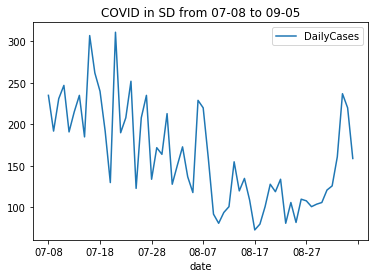

In [26]:
## graph last 14 days in sd 
sd_pv[-60:].plot(kind = 'line', title='COVID in SD from {} to {}'.format(sd_pv.index[-60], sd_pv.index[-1]))




In [27]:
## graphing last week compared to two weeks ago

In [28]:
## making dataframe for 

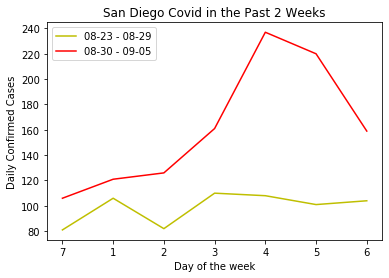

In [29]:
## could fix this so the two graphs overlap, and use the day 
## of the week as x axis
df_sd_twoweeks_before = df_sd[['dayOfWeek', 'DailyCases']].iloc[-14:-7]
df_sd_oneweek_before = df_sd[['dayOfWeek', 'DailyCases']].iloc[-7:]

plt.plot(df_sd_twoweeks_before['dayOfWeek'], df_sd_twoweeks_before['DailyCases'], label = '{} - {}'.format(df_sd['date'].iloc[-14], df_sd['date'].iloc[-8]), c = 'y')
plt.plot(df_sd_oneweek_before['dayOfWeek'], df_sd_oneweek_before['DailyCases'], label = '{} - {}'.format(df_sd['date'].iloc[-7], df_sd['date'].iloc[-1]), c = 'r')
plt.title('San Diego Covid in the Past 2 Weeks')
plt.ylabel('Daily Confirmed Cases')
plt.xlabel('Day of the week')
plt.legend()





In [30]:
## find out mean of week and see if there is a mismatch amongst days 
##hypothesis: tuesdays move the slowest? 


In [31]:
weekday_sd_pv = df_sd.pivot_table(index = 'dayOfWeek', values = 'DailyCases')



Text(0.5, 0, 'Day of Week')

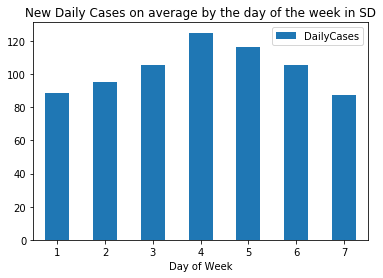

In [32]:
ax = weekday_sd_pv.plot(kind='bar', rot = 0, title = 'New Daily Cases on average by the day of the week in SD')
ax.set_xlabel('Day of Week')


## Comparing SD to nearby Cities 

In [33]:
## maybe more accurate to compare by population/million

In [34]:
#df_covid['City'].unique()

In [35]:
df_population = df_population[['NAME', 'POPESTIMATE2019']]
df_population.columns = ['City', 'Population']


In [36]:
##clean City column 
df_population['City'] = df_population['City'].str.replace('city', '')
df_population['City'] = df_population['City'].str.replace('town', '')
df_population['City'] = df_population['City'].str.strip()
df_population.drop_duplicates(inplace = True)


#df_population['City'].value_counts()

In [37]:
##getting df population with only cities in df_covid
cities = df_covid['City'].unique()

df_population = df_population[df_population['City'].isin(list(cities))]
df_population = df_population[['City', 'Population']]
#df_population.head()

In [38]:
## merging these datasets 
df_covid_pop = df_population.merge(df_covid, left_on='City', right_on='City', how = 'inner')
df_covid_pop = df_covid_pop.sort_values(by=['City', 'date'])
cities = list(df_covid_pop['City'].unique())
#cities




In [39]:
##forloop to get the dailycases per city
daily = []
for c in list(cities):
    #print(c)
    df_temp = df_covid_pop.loc[df_covid_pop['City'] == c, :]
    diff = df_temp['confirmedcases'] - df_temp['confirmedcases'].shift(1)
    #print(len(diff))
    daily.append(list(diff))

daily = list(chain.from_iterable(daily))
df_covid_pop['DailyCases'] = daily

#df_covid_pop.tail()  

In [40]:
## creating confirmed cases per million column 
df_covid_pop['DailyCases/Million'] = (df_covid_pop['DailyCases']/df_covid_pop['Population']*1000000)
#df_covid_pop.head()



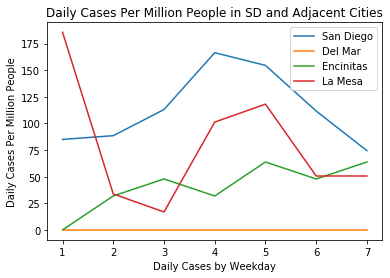

In [41]:
## Visualizing Cities in SD area in the past week by DailyCases/Million
## target adjacent cities 
ad_cities = ['San Diego', 'Del Mar', 'Encinitas', 'La Mesa']

for c in list(ad_cities):
    df_temp = df_covid_pop.loc[df_covid_pop['City'] == c, :]
    pv_temp = df_temp.iloc[-7:].pivot_table(index = 'dayOfWeek', values = 'DailyCases/Million')
    plt.plot(pv_temp, label = c)
    plt.ylabel("Daily Cases Per Million People" )
    plt.xlabel('Daily Cases by Weekday')
    plt.title('Daily Cases Per Million People in SD and Adjacent Cities')
    plt.legend()

Cannot draw reasonable conclusion to the graph above, so I'm proceeding with comparing major cities in Socal

In [42]:
## comparing SD to other major cities 

In [43]:
ca_population = ca_population[['NAME', 'POPESTIMATE2019']]
ca_population.columns = ['City', 'Population']

##clean City column 
ca_population['City'] = ca_population['City'].str.replace('city', '')
ca_population['City'] = ca_population['City'].str.replace('town', '')
ca_population['City'] = ca_population['City'].str.strip()
ca_population.drop_duplicates(inplace = True)


##getting df population with only cities in df_covid
ca_cities = cities_list
#print(ca_cities)

ca_population = ca_population[ca_population['City'].isin(list(ca_cities))]
ca_population = ca_population[['City', 'Population']]

## merging these datasets 
ca_covid = ca_population.merge(ca_covid, left_on='City', right_on='county', how = 'inner')
ca_covid = ca_covid.sort_values(by=['City', 'date'])
#cities = list(df_covid_pop['City'].unique())
#cities



In [44]:
ca_covid['DailyCases/Million'] = (ca_covid['newcountconfirmed']/df_covid_pop['Population']*1000000)



In [45]:
#ca_covid['City'].value_counts()

In [46]:
cities_list

['San Diego',
 'San Francisco',
 'Riverside',
 'Imperial',
 'Los Angeles',
 'Sacramento',
 'Orange',
 'Santa Clara']

In [47]:
def cal_covid(cities_list, days_before):
    aval = list(ca_covid['City'].unique())
    for c in list(cities_list):
        if c not in aval:
            print(c +" is not in the dataset")
            continue
        df_temp = ca_covid.loc[ca_covid['City'] == c, :]
        #print(df_temp)
        pv_temp = df_temp.iloc[-days_before:].pivot_table(index = 'date', values = 'DailyCases/Million')
    
        plt.plot(pv_temp, label = c)
        plt.ylabel("Daily Cases Per Million People" )
        plt.xlabel('Daily Cases by Weekday')
        plt.title('Daily Cases Per Million People in SD and Adjacent Cities')
        plt.legend()
    

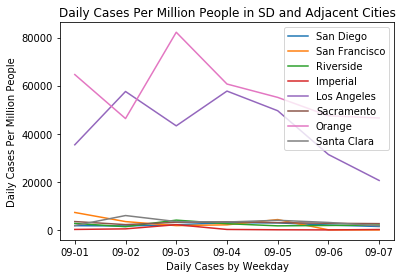

In [48]:
cal_covid(cities_list, 7)

In [49]:
cities_list_without_LA = ['San Diego',
 'San Francisco',
 'Imperial',
 'Sacramento',
 'Santa Clara']

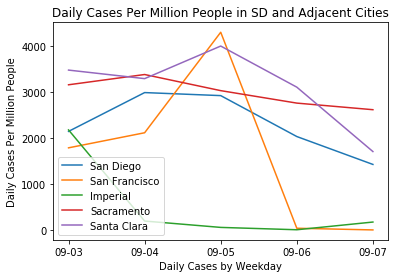

In [62]:
cal_covid(cities_list_without_LA, 5)

Compared to other major counties, especially LA and Orange County, San Diego seemingly has been keeping its new Positive Cases relatively low. However, excluding those two outliers in LA and Orange County, San Diego saw its biggest increase in mid June, two weeks after the stay at home order was alleviated, and dropped down gradually to an average level in mid July, one week after in door businesses were ordered to close down. 

## Hypothesis Testing 

San Diego entered phase 2 of reopening at 6/12. This includes the reopenning of public places like gyms, bars, museums and hotels. There is much speculation that this action would direct cause an increase of cases. While visualization supports the claim, null hypothesis testing would be needed to take place in order to obtain statistical evidence. Here, I compare the two groups, between the lock down and the reopenning(3/19 - 6/12), and between the reopening to today (6/12-6/28)

Null Hypothesis: the increase in COVID positive rate after is a result of random fluctuation, H0 = 0

Alternatvie Hypothesis: the increase in COVID positive rate this week is not a result of random fluctuation, H1 != 0

By random fluctuation, it is interpreted with the assumption that the average postive cases by day in San Diego stays relatively constant after the lockdown. This is supported by graphing the COVID daily cases in San Diego, where cases had been oscillating firmly around 75 cases a day since 3/19, the date where California issued a stay at home order. 

In [51]:
## project: this week compared to the average in weed since stay at home 
## order being implemented

In [52]:
## get the weekly average between the stay at home order and reopen 
## reindex 
index_list = []
index_list = list(range(0, len(df_sd)))
df_sd.index = index_list
## get index of day of stay at home order
start = df_sd[df_sd['date'] == '03-20'].index
end = df_sd[df_sd['date'] == '06-12'].index

##get the df for stay at home order
df_sd_stay_at_home = df_sd.iloc[start[0]: end[0]]

## get the df for reopening 
df_sd_reopen = df_sd.iloc[end[0]:]



In [53]:
## get pv table for daily averages per day of week for df_stay_at_home and df_reopen
pv_weekday_sd_stay_at_home = df_sd_stay_at_home.pivot_table(index = 'dayOfWeek', values = 'DailyCases')
pv_weekday_sd_reopen = df_sd_reopen.pivot_table(index = 'dayOfWeek', values = 'DailyCases')


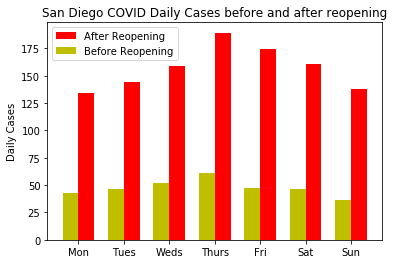

In [54]:
## graphing the two 
N = 7
ind = pv_weekday_sd_reopen.index  # the x locations for the groups
width = 0.35       # the width of the bars
pos = np.arange(N)+1
fig,ax = plt.subplots()

## creating rectangles for ax
rects1 = ax.bar(pos+width, pv_weekday_sd_reopen['DailyCases'], width, color = 'r')
rects2 = ax.bar(pos, pv_weekday_sd_stay_at_home['DailyCases'], width, color = 'y')

ax.set_ylabel('Daily Cases')
ax.set_title('San Diego COVID Daily Cases before and after reopening')
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(('Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun'))

ax.legend((rects1[0], rects2[0]), ('After Reopening', 'Before Reopening'))

In [55]:
## calculate average increase 
df_sd_stay_at_home.head()

,City,confirmedcases,date,dayOfWeek,DailyCases
0,San Diego,87.0,03-20,5,NaN
1,San Diego,118.0,03-21,6,31.0
2,San Diego,134.0,03-22,7,16.0
3,San Diego,141.0,03-23,1,7.0
4,San Diego,169.0,03-24,2,28.0


In [56]:
type(ind)

pandas.core.indexes.base.Index

In [57]:
## conduct 1 tail student t test 
t, p = stats.ttest_ind(df_sd_stay_at_home['DailyCases'], df_sd_reopen['DailyCases'], nan_policy='omit')
print('The T Score is {:.2f}, and the P-value is {:.2f}'.format(t, p))

The T Score is -15.42, and the P-value is 0.00


In [58]:
## make this p value test better

In [59]:
## trumps approval rate by state vs Daily New Cases rate 